In [ ]:
# <<< --- Part 1: DL-BASED SENTIMENT PREDICTION --- >>>

In [ ]:
#⚙️ Step 0: Install & Import Dependencies

In [1]:
!pip install tensorflow pandas scikit-learn nltk

import pandas as pd
import numpy as np
import re
import string
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#📦 Step 1: Load and Combine Title + Review

In [3]:
import pandas as pd

# Load your CSV
df = pd.read_csv('/content/reviews.csv')  # Adjust path if needed

# Define rule-based mapping from title to sentiment
positive_titles = ['Impressive', 'Fantastic Experience', 'Very Helpful', 'Superb!', 'Great Tool!']
negative_titles = ['Waste of Time', 'Not Accurate', 'Too Slow', 'Buggy']
neutral_titles = ['Needs Improvement']

def map_sentiment(title):
    title = str(title).strip()
    if title in positive_titles:
        return 'Positive'
    elif title in negative_titles:
        return 'Negative'
    elif title in neutral_titles:
        return 'Neutral'
    else:
        return None

df['sentiment'] = df['title'].apply(map_sentiment)

# Drop rows with undefined sentiment
df = df.dropna(subset=['sentiment', 'review'])


In [ ]:
#🧹 Step 2: Clean and Preprocess Reviews

In [7]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

df['clean_review'] = df['review'].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#🧠 Step 3: Tokenize and Encode

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Inputs and labels
X = df['clean_review'].values
y = df['sentiment'].values

# Encode sentiment labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # 0 = Negative, 1 = Neutral, 2 = Positive

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=150)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)


In [ ]:
#🧠 Step 4: Build and Train BiLSTM Model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=150))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 395ms/step - accuracy: 0.4804 - loss: 0.9788 - val_accuracy: 0.5025 - val_loss: 0.9508
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 414ms/step - accuracy: 0.5037 - loss: 0.9408 - val_accuracy: 0.4870 - val_loss: 0.9566
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 372ms/step - accuracy: 0.5595 - loss: 0.8979 - val_accuracy: 0.4730 - val_loss: 0.9857
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.5920 - loss: 0.8550 - val_accuracy: 0.4810 - val_loss: 1.0082
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 388ms/step - accuracy: 0.6154 - loss: 0.8065 - val_accuracy: 0.4605 - val_loss: 1.0650


In [ ]:
#💾 Step 5: Save Model & Tokenizer

In [ ]:
model.save('sentiment_model.h5')

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)


In [ ]:
# ---- PREDICTION SECTION ----

In [ ]:
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the trained model
model = tf.keras.models.load_model('sentiment_model.h5')

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load label encoder
with open('label_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)


In [12]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

def predict_sentiment(review_text):
    cleaned = clean_text(review_text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=150)
    prediction = model.predict(padded)
    predicted_class = prediction.argmax(axis=-1)[0]
    sentiment = encoder.inverse_transform([predicted_class])[0]
    return sentiment


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
review = "Husband point record table resource. Agree successful stay dark truth network true. Though feeling right walk red order."
print("Predicted Sentiment:", predict_sentiment(review))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted Sentiment: Neutral


In [ ]:
# <<< --- Part 2: BUSINESS INSIGHTS AND ANALYTICS --- >>>

In [ ]:
#📥 Step 1: Load & Explore the Dataset

In [32]:
import pandas as pd

# Load data
df = pd.read_csv("/content/reviews.csv")

# Quick look
df.head()
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               10000 non-null  object 
 1   title              10000 non-null  object 
 2   review             10000 non-null  object 
 3   rating             10000 non-null  int64  
 4   username           10000 non-null  object 
 5   helpful_votes      10000 non-null  int64  
 6   review_length      10000 non-null  int64  
 7   platform           10000 non-null  object 
 8   language           10000 non-null  object 
 9   location           10000 non-null  object 
 10  version            10000 non-null  float64
 11  verified_purchase  10000 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 937.6+ KB


,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
count,10000,10000,10000,10000.000000,10000,10000.000000,10000.000000,10000,10000,10000,10000.000000,10000
unique,366,10,10000,NaN,9460,NaN,NaN,2,5,6,NaN,2
top,1/10/2025,Buggy,Painting likely land ability it. Administratio...,NaN,owilliams,NaN,NaN,Mobile,en,Canada,NaN,No
freq,44,1037,1,NaN,6,NaN,NaN,5011,2016,1711,NaN,5116
mean,NaN,NaN,NaN,2.987000,NaN,50.347800,147.034000,NaN,NaN,NaN,3.651070,NaN
std,NaN,NaN,NaN,1.424161,NaN,28.914613,34.911708,NaN,NaN,NaN,0.438935,NaN
min,NaN,NaN,NaN,1.000000,NaN,0.000000,30.000000,NaN,NaN,NaN,3.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,25.000000,122.000000,NaN,NaN,NaN,3.500000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,50.000000,151.000000,NaN,NaN,NaN,4.000000,NaN
75%,NaN,NaN,NaN,4.000000,NaN,75.000000,176.000000,NaN,NaN,NaN,4.100000,NaN


In [ ]:
#🧹 Step 2: Clean and Prepare

In [33]:
# Drop irrelevant or high-missing columns
df = df.drop(columns=['username'])

# Fill missing reviews or drop rows
df = df.dropna(subset=['title', 'review', 'rating'])

# Ensure correct dtypes
df['rating'] = df['rating'].astype(int)
df['date'] = pd.to_datetime(df['date'])

# If not already in dataset
df['review_length'] = df['review'].apply(lambda x: len(str(x)))


In [ ]:
#📌 Step 3: Derive Sentiment from Rating

In [34]:
def map_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['rating'].apply(map_sentiment)


In [ ]:
#--- Insights and Analysis ---

<ipython-input-36-164ab3efe6e7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='coolwarm')


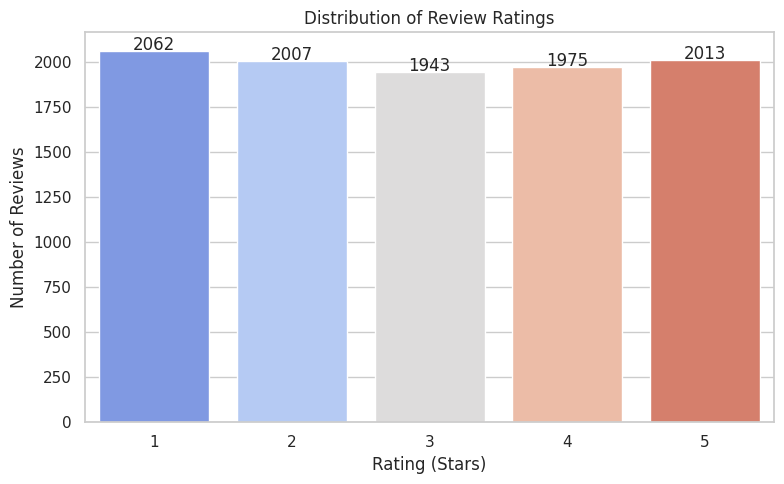

In [36]:
# 📊 Insight 1: Distribution of Review Ratings

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Countplot of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='coolwarm')

rating_counts = df['rating'].value_counts().sort_index()

for i, count in enumerate(rating_counts):
    plt.text(i, count + 5, str(count), ha='center')


# Labels and title
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating (Stars)')
plt.ylabel('Number of Reviews')

# Show
plt.tight_layout()
plt.show()


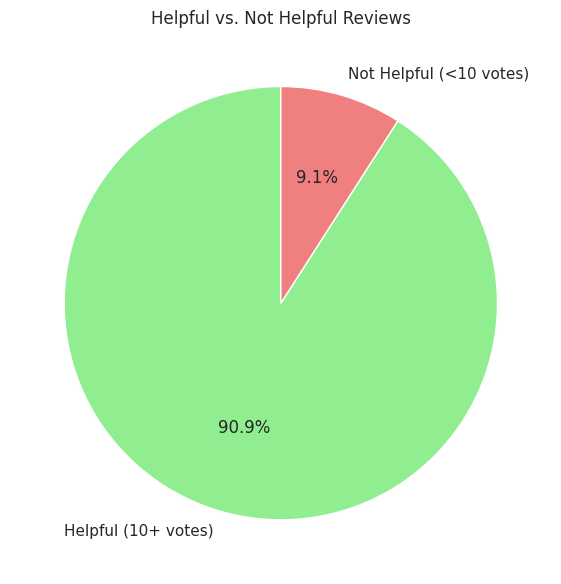

In [37]:
#👍👎 Insight 2: Helpful Reviews Analysis

import matplotlib.pyplot as plt

# Classify reviews as Helpful or Not Helpful
df['helpful_flag'] = df['helpful_votes'].apply(lambda x: 'Helpful (10+ votes)' if x >= 10 else 'Not Helpful (<10 votes)')

# Plot pie chart
plt.figure(figsize=(6, 6))
df['helpful_flag'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'], startangle=90)
plt.title('Helpful vs. Not Helpful Reviews')
plt.ylabel('')  # Remove y-label
plt.tight_layout()
plt.show()


In [39]:
#☁️ Insight 3: Word Clouds for Positive vs. Negative Reviews

# Define sentiment mapping manually from known titles
positive_titles = ["Impressive", "Fantastic Experience", "Very Helpful", "Superb!", "Great Tool!"]
negative_titles = ["Waste of Time", "Not Accurate", "Needs Improvement", "Too Slow", "Buggy"]

# Assign sentiment class
df['sentiment'] = df['title'].apply(
    lambda x: 'Positive' if x in positive_titles else ('Negative' if x in negative_titles else 'Neutral')
)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


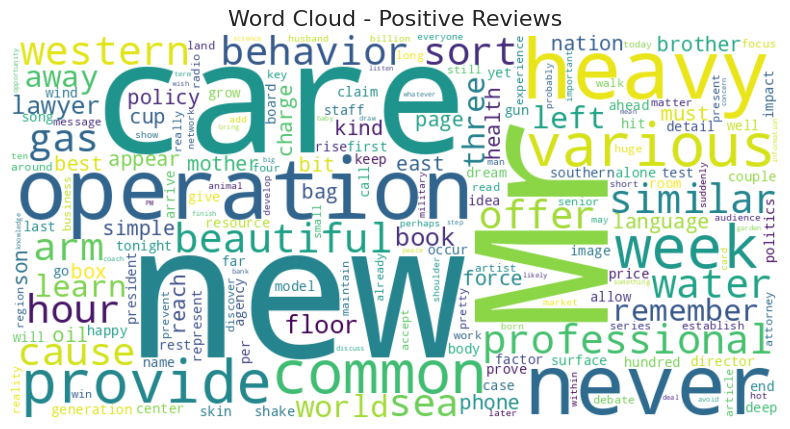

In [40]:
# Positive reviews word cloud
plot_wordcloud(df[df['sentiment'] == 'Positive']['review'], 'Word Cloud - Positive Reviews')


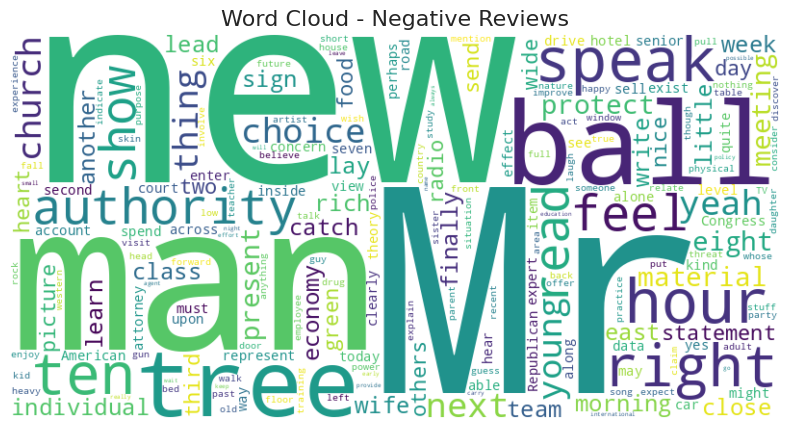

In [41]:
# Negative reviews word cloud
plot_wordcloud(df[df['sentiment'] == 'Negative']['review'], 'Word Cloud - Negative Reviews')


<ipython-input-42-2faf7a10509e>:22: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


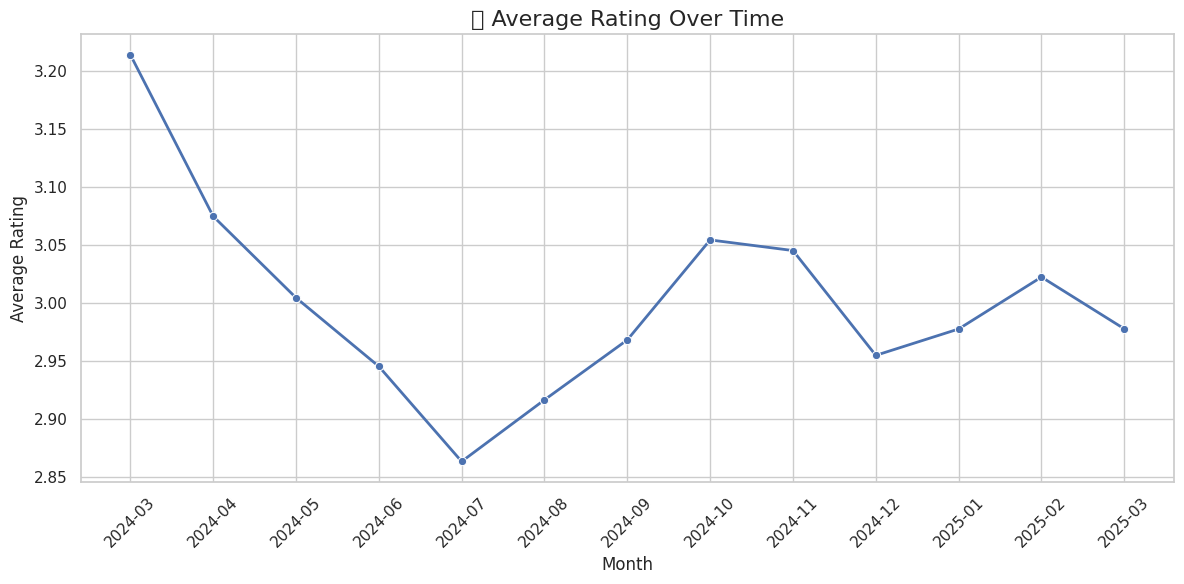

In [42]:
#📆 Insight 4: How Has the Average Rating Changed Over Time?

# Ensure 'date' is datetime type
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows where date parsing failed
df = df.dropna(subset=['date'])

# Group by week or month (depending on granularity desired)
df['month'] = df['date'].dt.to_period('M')
monthly_avg = df.groupby('month')['rating'].mean().reset_index()
monthly_avg['month'] = monthly_avg['month'].astype(str)

#Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x='month', y='rating', marker='o', linewidth=2)
plt.xticks(rotation=45)
plt.title('📆 Average Rating Over Time', fontsize=16)
plt.ylabel('Average Rating')
plt.xlabel('Month')
plt.tight_layout()
plt.grid(True)
plt.show()


In [47]:
#🌍 Insight 5: How Do Ratings Vary by User Location?

# Drop rows with missing or invalid location/rating
df_location = df.dropna(subset=['location', 'rating'])

# Group by location and calculate average rating
location_avg = df_location.groupby('location')['rating'].mean().reset_index()
location_avg = location_avg.sort_values(by='rating', ascending=False)

#Visualize
import plotly.express as px

fig = px.choropleth(
    location_avg,
    locations='location',
    locationmode='country names',
    color='rating',
    color_continuous_scale='Plasma',
    title='🌍 Average Rating by Country',
)
fig.show()


In [ ]:
#💻📱 Insight 6: Which Platform Gets Better Reviews — Web or Mobile?

<ipython-input-51-5f15dad496b6>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.



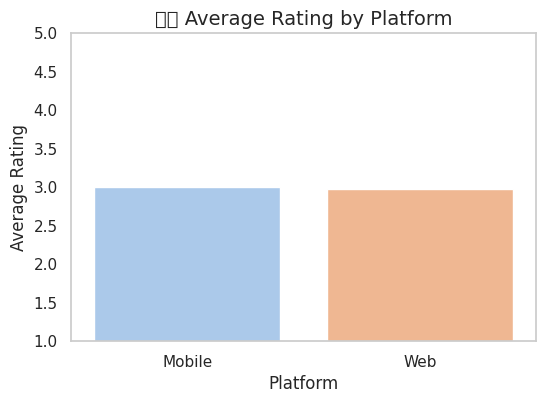

📱 Platform: Mobile → Average Rating: 3.00
📱 Platform: Web → Average Rating: 2.97
✅ The platform with the higher average rating is: **Mobile** with an average rating of 3.00


In [51]:
# Drop missing platform or rating values
df_platform = df.dropna(subset=['platform', 'rating'])

# Group by platform and calculate average rating
platform_avg = df_platform.groupby('platform')['rating'].mean().reset_index()

#Visualize
plt.figure(figsize=(6, 4))
sns.barplot(data=platform_avg, x='platform', y='rating', palette='pastel')
plt.title('💻📱 Average Rating by Platform', fontsize=14)
plt.xlabel('Platform')
plt.ylabel('Average Rating')
plt.ylim(1, 5)
plt.grid(axis='y')
plt.show()

#Show average ratings
for index, row in platform_avg.iterrows():
    print(f"📱 Platform: {row['platform']} → Average Rating: {row['rating']:.2f}")

# Determine which platform has the higher average rating
best_platform = platform_avg.sort_values(by='rating', ascending=False).iloc[0]
print(f"✅ The platform with the higher average rating is: **{best_platform['platform']}** with an average rating of {best_platform['rating']:.2f}")


<ipython-input-53-8ad47db87e90>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.



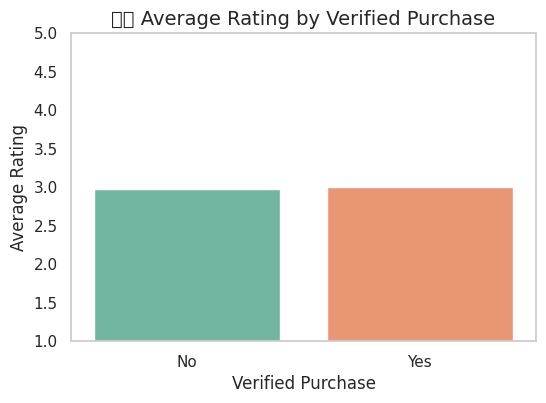

  verified_purchase    rating
0                No  2.971071
1               Yes  3.003686


In [53]:
#✅❌ Insight 7: Are Verified Users More Satisfied Than Non-Verified Ones?

# Clean up and prepare data
df_verified = df.dropna(subset=['verified_purchase', 'rating'])

# Calculate average ratings
verified_avg = df_verified.groupby('verified_purchase')['rating'].mean().reset_index()

#Visualize
plt.figure(figsize=(6, 4))
sns.barplot(data=verified_avg, x='verified_purchase', y='rating', palette='Set2')
plt.title('✅❌ Average Rating by Verified Purchase', fontsize=14)
plt.xlabel('Verified Purchase')
plt.ylabel('Average Rating')
plt.ylim(1, 5)
plt.grid(axis='y')
plt.show()

print(verified_avg)

<ipython-input-55-afac59d087f2>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-55-afac59d087f2>:24: UserWarning:

Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.



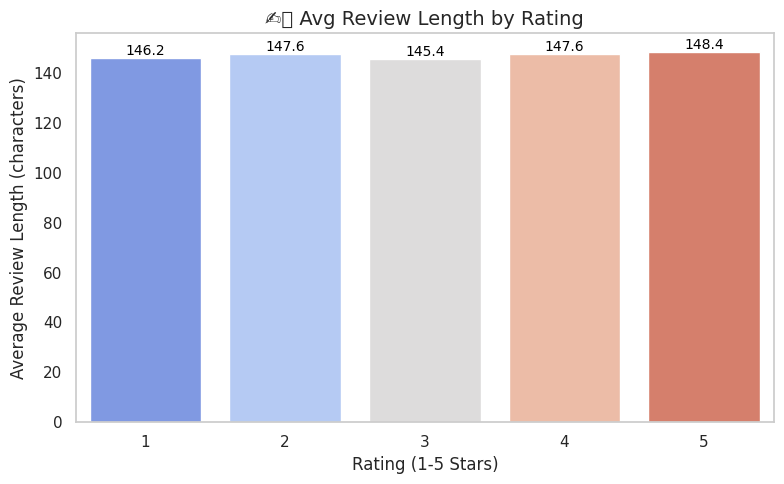

In [55]:
#✍️📏 Insight 8: What’s the Average Length of Reviews per Rating?

# Ensure review_length and rating are present
df_length = df.dropna(subset=['rating', 'review_length'])

# Group by rating and calculate average length
length_by_rating = df_length.groupby('rating')['review_length'].mean().reset_index()

#Visualize

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=length_by_rating, x='rating', y='review_length', palette='coolwarm')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('✍️📏 Avg Review Length by Rating', fontsize=14)
plt.xlabel('Rating (1-5 Stars)')
plt.ylabel('Average Review Length (characters)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [56]:
#💬🔍  Insight 9: What Are the Most Common Words in 1-Star Reviews?

from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Filter 1-star reviews
one_star_reviews = df[df['rating'] == 1]['review']

# Clean and tokenize the text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

cleaned_reviews = one_star_reviews.apply(clean_text)

# Tokenize and count word frequencies
word_counts = Counter(' '.join(cleaned_reviews).split())

# Extract the top 10 most frequent words
top_words = word_counts.most_common(10)
top_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('move', 70),
 ('tree', 68),
 ('staff', 67),
 ('represent', 67),
 ('heart', 65),
 ('long', 65),
 ('heavy', 65),
 ('meeting', 64),
 ('station', 63),
 ('class', 63)]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.



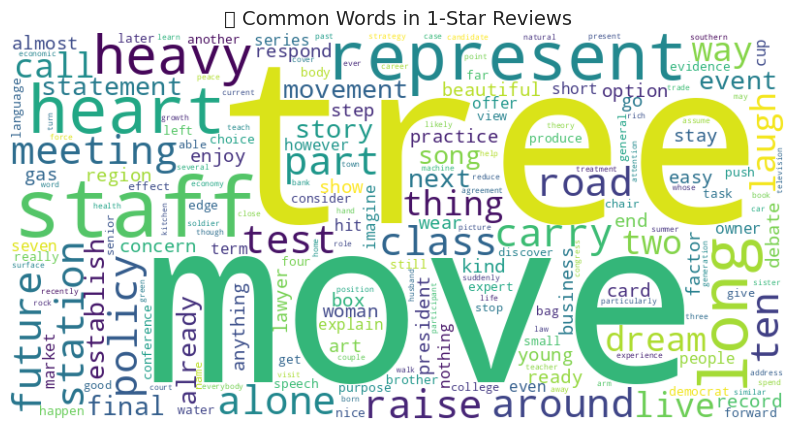

In [57]:
from wordcloud import WordCloud

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("💬 Common Words in 1-Star Reviews", fontsize=14)
plt.axis('off')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.



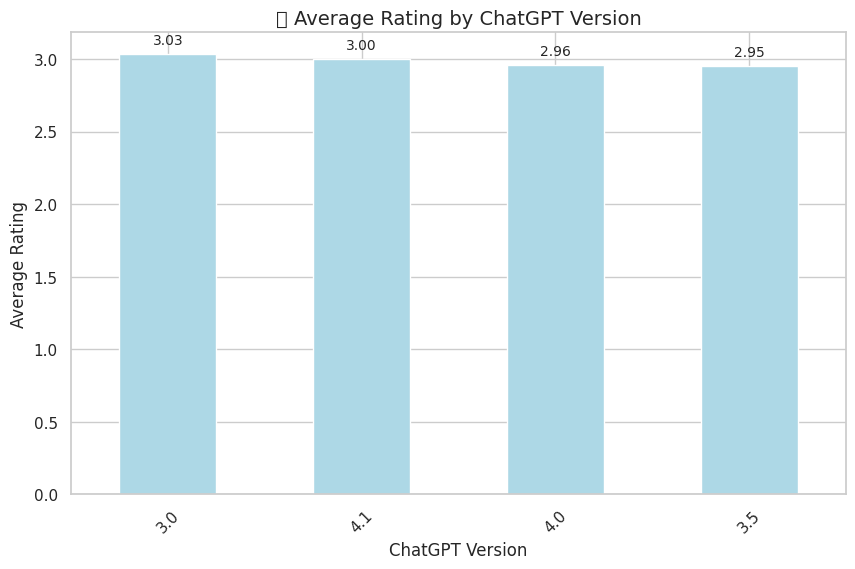

In [59]:
#📱🧪 Insight 10: Which ChatGPT Version Received the Highest Average Rating?

# Group by 'version' and calculate the average rating
version_avg_rating = df.groupby('version')['rating'].mean().sort_values(ascending=False)

# Plotting the average rating per version with values on the bars
plt.figure(figsize=(10, 6))
ax = version_avg_rating.plot(kind='bar', color='lightblue')
plt.title("📱 Average Rating by ChatGPT Version", fontsize=14)
plt.xlabel("ChatGPT Version", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(rotation=45)

# Add values on top of bars
for i in ax.patches:
    ax.annotate(f'{i.get_height():.2f}',
                (i.get_x() + i.get_width() / 2., i.get_height()),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=10)

plt.show()



In [ ]:
#<< --- Key Questions for Sentiment Analysis --- >>

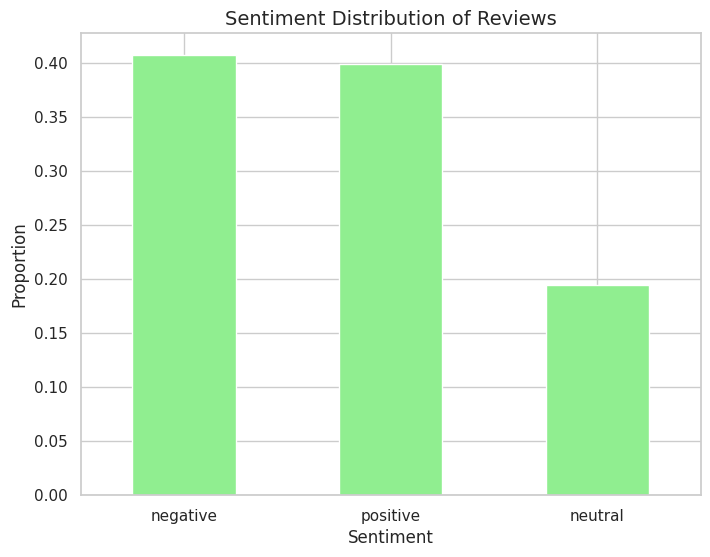

In [73]:
#1. What is the overall sentiment of user reviews?

import matplotlib.pyplot as plt
import pandas as pd

# Manually derive sentiment based on rating
def derive_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to the 'rating' column
df['sentiment'] = df['rating'].apply(derive_sentiment)

# Calculate sentiment distribution
sentiment_distribution = df['sentiment'].value_counts(normalize=True)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color='lightgreen')
plt.title("Sentiment Distribution of Reviews", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xticks(rotation=0)
plt.show()


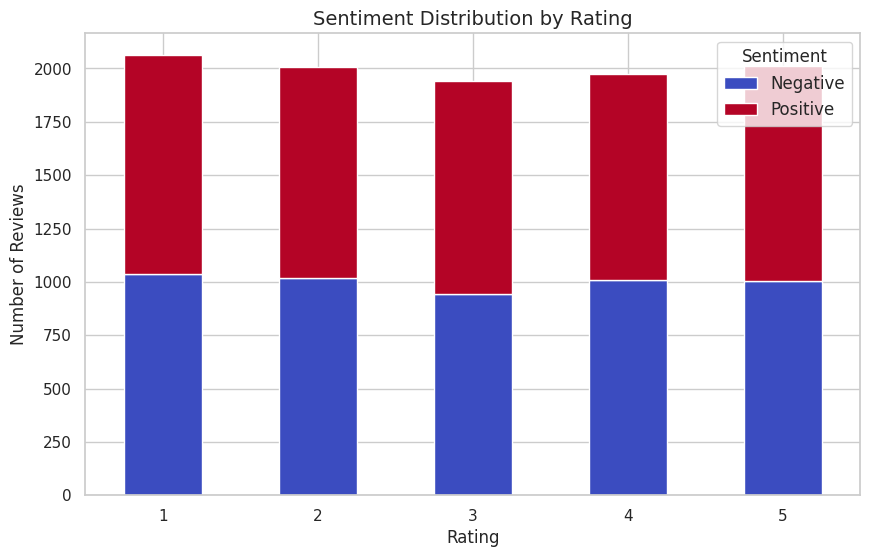

In [61]:
#2. How does sentiment vary by rating?

# Group by rating and sentiment
rating_sentiment = df.groupby(['rating', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment distribution by rating
rating_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title("Sentiment Distribution by Rating", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentiment', fontsize=12)
plt.show()


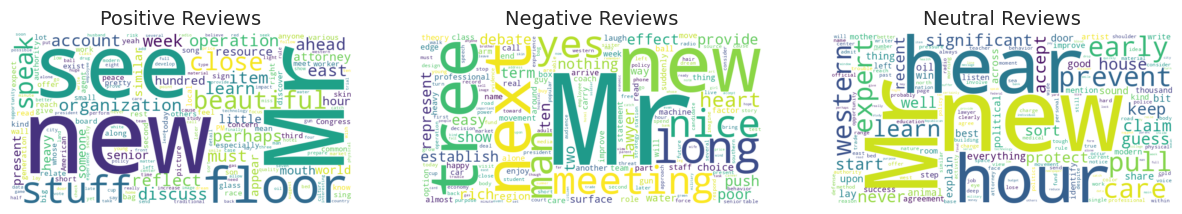

In [74]:
#3. Which keywords or phrases are most associated with each sentiment class?

from wordcloud import WordCloud

# Separate reviews by sentiment
positive_reviews = df[df['sentiment'] == 'positive']['review']
negative_reviews = df[df['sentiment'] == 'negative']['review']
neutral_reviews = df[df['sentiment'] == 'neutral']['review']

# Create word clouds for each sentiment type
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(neutral_reviews))

# Plot word clouds
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews', fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews', fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Reviews', fontsize=14)
plt.axis('off')

plt.show()


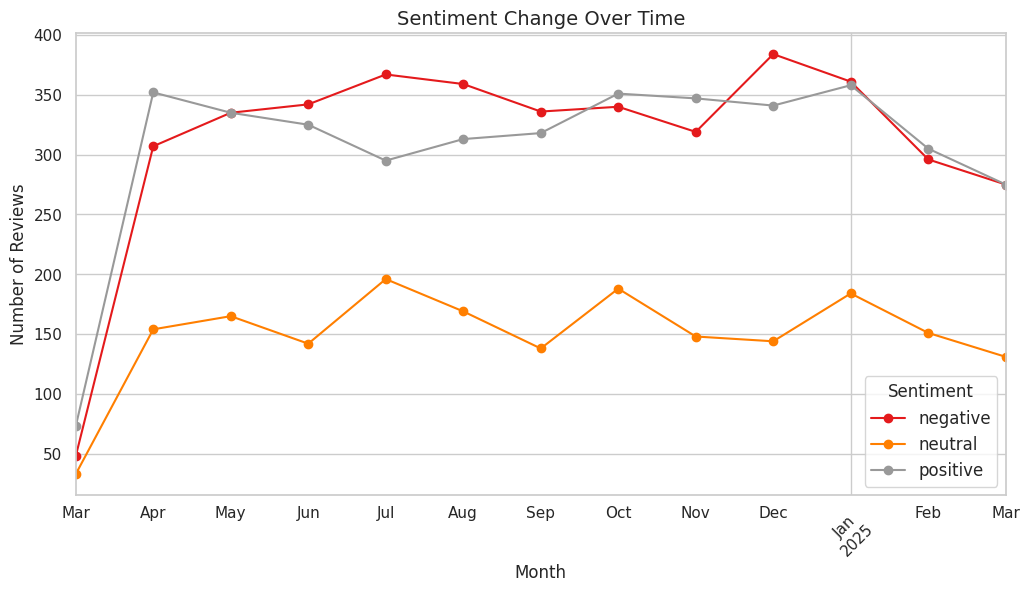

In [75]:
#4. How has sentiment changed over time?

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year-month for grouping
df['month'] = df['date'].dt.to_period('M')

# Group by month and sentiment
monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment change over time
monthly_sentiment.plot(kind='line', figsize=(12, 6), marker='o', colormap='Set1')
plt.title("Sentiment Change Over Time", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', fontsize=12)
plt.show()


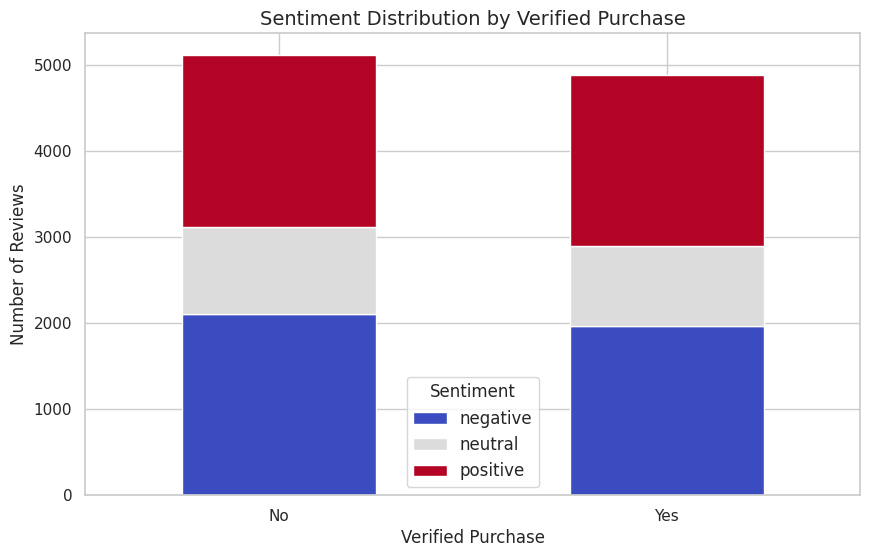

In [76]:
#5. Do verified users tend to leave more positive or negative reviews?

# Group by verified_purchase and sentiment
verified_sentiment = df.groupby(['verified_purchase', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment distribution by verified purchase status
verified_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title("Sentiment Distribution by Verified Purchase", fontsize=14)
plt.xlabel("Verified Purchase", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentiment', fontsize=12)
plt.show()


<ipython-input-79-00415a68ba46>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




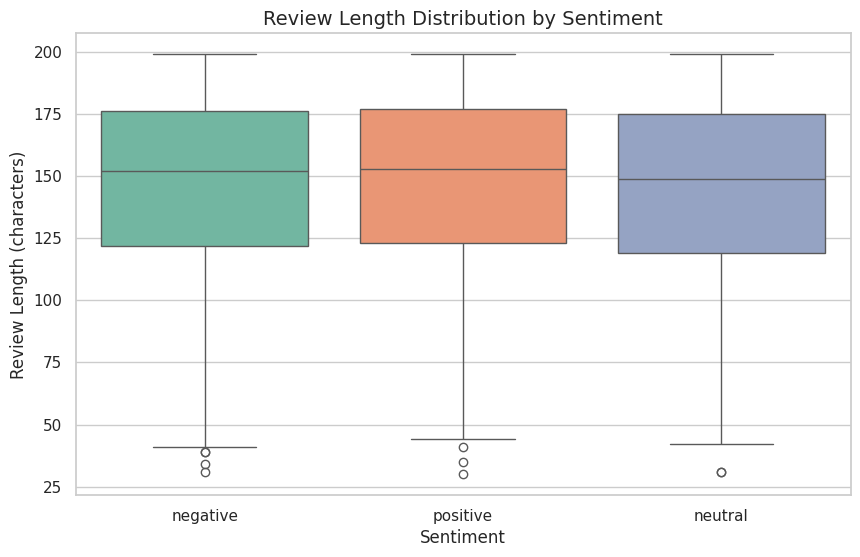

Average Review Length by Sentiment:
sentiment
negative    146.847628
neutral     145.413278
positive    148.013791
Name: review_length, dtype: float64


In [79]:
#6. Are longer reviews more likely to be negative or positive?

import seaborn as sns
import matplotlib.pyplot as plt

# Create a sentiment score mapping
sentiment_score = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['sentiment'].map(sentiment_score)

# Boxplot: Review Length vs Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df, palette='Set2')
plt.title("Review Length Distribution by Sentiment", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Review Length (characters)", fontsize=12)
plt.show()

# Calculate average review length for each sentiment
avg_review_length = df.groupby('sentiment')['review_length'].mean()
print("Average Review Length by Sentiment:")
print(avg_review_length)


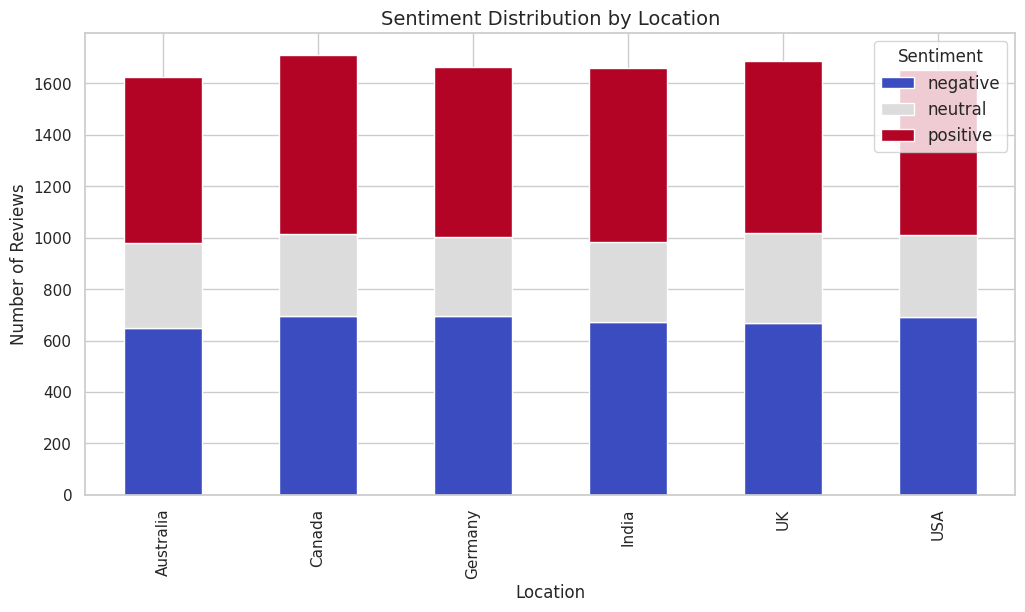

Location with most positive sentiment: ('Canada', 695)
Location with most negative sentiment: ('Germany', 695)


In [82]:
#7. Which locations show the most positive or negative sentiment?

# Group by location and sentiment
location_sentiment = df.groupby(['location', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment distribution by location
location_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title("Sentiment Distribution by Location", fontsize=14)
plt.xlabel("Location", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Sentiment', fontsize=12)
plt.show()

# Optional: Find the locations with most positive and negative sentiment
positive_sentiment = location_sentiment['positive'] if 'positive' in location_sentiment.columns else pd.Series()
negative_sentiment = location_sentiment['negative'] if 'negative' in location_sentiment.columns else pd.Series()

# Find top locations for positive and negative sentiment
top_positive_locations = positive_sentiment.idxmax(), positive_sentiment.max()
top_negative_locations = negative_sentiment.idxmax(), negative_sentiment.max()

print("Location with most positive sentiment:", top_positive_locations)
print("Location with most negative sentiment:", top_negative_locations)



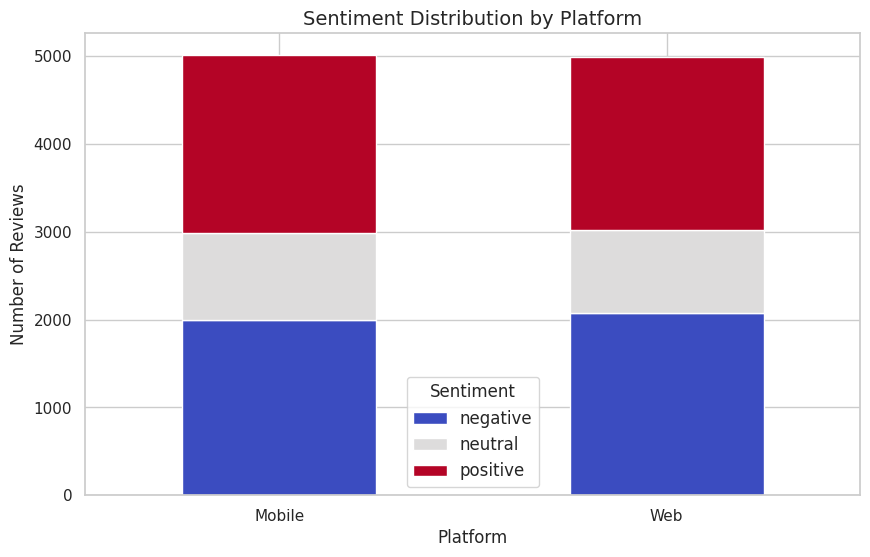

In [85]:
#8. Is there a difference in sentiment across platforms (Web vs Mobile)?

# Group by platform and sentiment
platform_sentiment = df.groupby(['platform', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment distribution by platform
platform_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title("Sentiment Distribution by Platform", fontsize=14)
plt.xlabel("Platform", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentiment', fontsize=12)
plt.show()


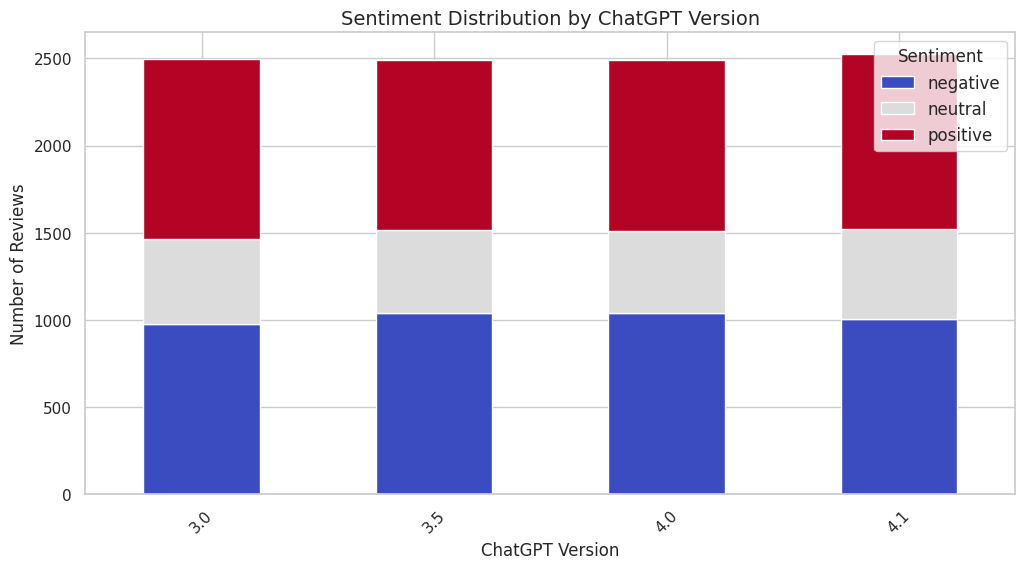

In [86]:
#9. Which ChatGPT versions are associated with higher/lower sentiment?

# Group by version and sentiment
version_sentiment = df.groupby(['version', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment distribution by version
version_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title("Sentiment Distribution by ChatGPT Version", fontsize=14)
plt.xlabel("ChatGPT Version", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', fontsize=12)
plt.show()


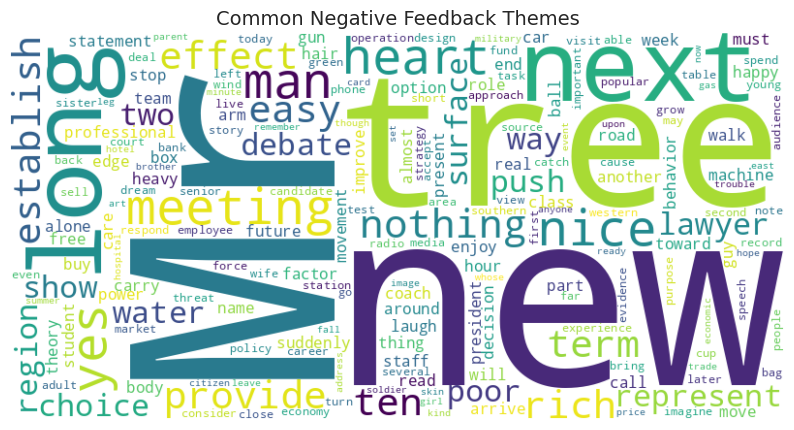

In [87]:
#10. What are the most common negative feedback themes?

# Extract negative reviews
negative_reviews_text = ' '.join(df[df['sentiment'] == 'negative']['review'])

# Generate a word cloud for negative feedback
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews_text)

# Plot word cloud for negative reviews
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title("Common Negative Feedback Themes", fontsize=14)
plt.axis('off')
plt.show()


In [1]:
import joblib

# Save model
joblib.dump(model, "model.pkl")

# Save vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")

# Save cleaned dataset
df.to_csv("dataset.csv", index=False)


NameError: name 'model' is not defined

In [ ]:
from google.colab import files
files.download("model.pkl")
files.download("vectorizer.pkl")
files.download("dataset.csv")
